In [ ]:
!git clone https://github.com/YRL-AIDA/T5-GlyF.git
%cd T5-GlyF

Cloning into 'T5-GlyF'...
remote: Enumerating objects: 124, done.
remote: Counting objects: 100% (124/124), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 124 (delta 28), reused 117 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (124/124), 2.50 MiB | 8.36 MiB/s, done.
Resolving deltas: 100% (28/28), done.
/content/T5-GlyF


In [ ]:
!pip install -r requirements.txt

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils import load_pkl, save_pkl, load_json
from glyf.data_processing.glyph_processor import GlyphProcessor, GenerationMethod

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
path_to_glyphs = 'data/external/homoglyphs.pkl'
glyphs_dict = load_pkl(path_to_glyphs)
processor = GlyphProcessor(glyphs_dict)
print(processor.__doc__)


  GlyphProcessor - a tool for data analysis and generation.
  :param glyphs_dict: a dictionary where the key is a correct glyph, the value is a list of its homoglyphs -> {'a' : ['а', ...]};
  


In [5]:
path_to_preprocessed_data = 'data/preprocessed/dictionary_sentences_balanced.pkl'
preprocessed_data = load_pkl(path_to_preprocessed_data)
available_glyphs = list(glyphs_dict.keys())
print(processor.analyze_sentences.__doc__)


    Analyzes input sentences.

    :param sentences: list of sentences to analyze;
    :param available_letters: list of letters (glyphs) for which statistics will be calculated;
    :return: pandas DataFrame with main statistics, mean length of words, mean length of sentences.
    


In [6]:
df, mean_word_length, mean_sentence_length = processor.analyze_sentences(preprocessed_data, available_glyphs)
df.head()

100%|██████████| 376410/376410 [01:09<00:00, 5378.29it/s] 


Mean word`s length: 5.400849966718886
Mean sentence`s length: 60.157514412475756
Count of letters: 18243468
--------------------


,letters,count,frequency,freq%,priority
0,a,738459.0,0.040478,4.047799,0.959522
1,b,146279.0,0.008018,0.801816,0.991982
2,c,318495.0,0.017458,1.745803,0.982542
3,d,292509.0,0.016034,1.603363,0.983966
4,e,1035870.0,0.056780,5.678032,0.943220


In [7]:
# Relative Frequencies of Letters in General English Plain text
# From Cryptographical Mathematics, by Robert Edward Lewand
char_freqs = {
	'a':	0.08167,
	'b':	0.01492,
	'c':	0.02782,
	'd':	0.04253,
	'e':	0.12702,
	'f':	0.02228,
	'g':	0.02015,
	'h':	0.06094,
	'i':	0.06966,
	'j':	0.00153,
	'k':	0.00772,
	'l':	0.04025,
	'm':	0.02406,
	'n':	0.06749,
	'o':	0.07507,
	'p':	0.01929,
	'q':	0.00095,
	'r':	0.05987,
	's':	0.06327,
	't':	0.09056,
	'u':	0.02758,
	'v':	0.00978,
	'w':	0.02360,
	'x':	0.00150,
	'y':	0.01974,
	'z':	0.00074
}

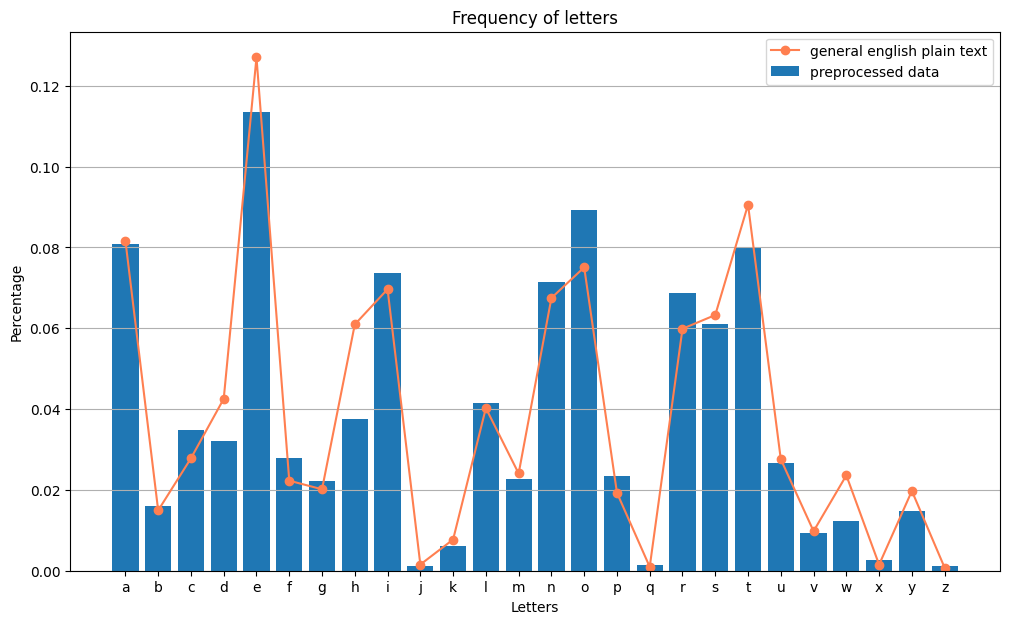

In [8]:
letters = list(char_freqs.keys())
freq_english = list(char_freqs.values())
# only lowercase letters are needed => length//2, frequency*2
freq_preprocessed_data = df['frequency'][:df.shape[0]//2]*2

plt.figure(figsize=(12, 7))
plt.bar(letters, freq_preprocessed_data, label='preprocessed data')
plt.plot(letters, freq_english, c='coral', marker='o', label='general english plain text')
plt.xlabel('Letters')
plt.ylabel('Percentage')
plt.title('Frequency of letters')
plt.legend()
plt.grid(True, axis='y')
plt.rc('axes', axisbelow=True)
plt.show()

In [9]:
method = GenerationMethod.by_size
priority = dict(df.set_index('letters')['priority'].to_dict().items())
limits = [
    [50, 0, 0.75],
    [150, 0, 0.4],
    [300, 0, 0.1]
  ]
print(processor.perturbate.__doc__)


    Generates dataset (makes perturbations in sentences by replacing glyphs with their homoglyphs).

    :param sentences: list of sentences to perturbate;
    :param method: generation method (check enum GenerationMethod);
    :param priority: a dictionary where the key is a correct glyph, the value is its priority (reverse frequency);
    :param min_perturb: a minimum count of perturbations in a single sentence (default = 1);
    :param max_perturb: a maximum count of perturbations in a single sentence (default = 1);
    :param limits: generation limits ([sentences_length, %min_perturb, %max_perturb]) if you choose GenerationMethod.by_size (default = []);
    :return: dataset with perturbations in sentences.
    


In [10]:
dataset = processor.perturbate(preprocessed_data, method, priority, limits=limits)
print(f'Length of the dataset: {len(dataset)}')

100%|██████████| 376410/376410 [12:35<00:00, 498.14it/s] 

Length of the dataset: 8872562


In [11]:
# take only sentences with homoglyphs from the pair
only_homoglyph_sentences = [x[0] for x in dataset]
# list of lists of homoglyphs to one big list of homoglyphs
available_homoglyphs = list(set(sum(list(glyphs_dict.values()), [])))
df_homoglyphs, mwl, msl = processor.analyze_sentences(only_homoglyph_sentences, available_homoglyphs)

100%|██████████| 8872562/8872562 [58:34<00:00, 2524.32it/s] 



Mean word`s length: 5.019483909335402
Mean sentence`s length: 77.09960099461689
Count of letters: 172199506
--------------------


In [12]:
df_homoglyphs.head()

,letters,count,frequency,freq%,priority
0,һ,391694.0,0.002275,0.227465,0.997725
1,i,16703517.0,0.097001,9.700096,0.902999
2,ⱬ,21790.0,0.000127,0.012654,0.999873
3,ṭ,1166368.0,0.006773,0.677335,0.993227
4,ì,870237.0,0.005054,0.505366,0.994946


In [30]:
df_homoglyphs.shape[0], df_homoglyphs[df_homoglyphs['count'] == 0]

(237,
 Empty DataFrame
 Columns: [letters, count, frequency, freq%, priority]
 Index: [])

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7564 (\N{LATIN SMALL LETTER V WITH PALATAL HOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 42926 (\N{LATIN CAPITAL LETTER SMALL CAPITAL I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 7934 (\N{LATIN CAPITAL LETTER Y WITH LOOP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 42949 (\N{LATIN CAPITAL LETTER S WITH HOOK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 42924 (\N{LATIN CAPITAL LETTER SCRIPT G}) missing fro

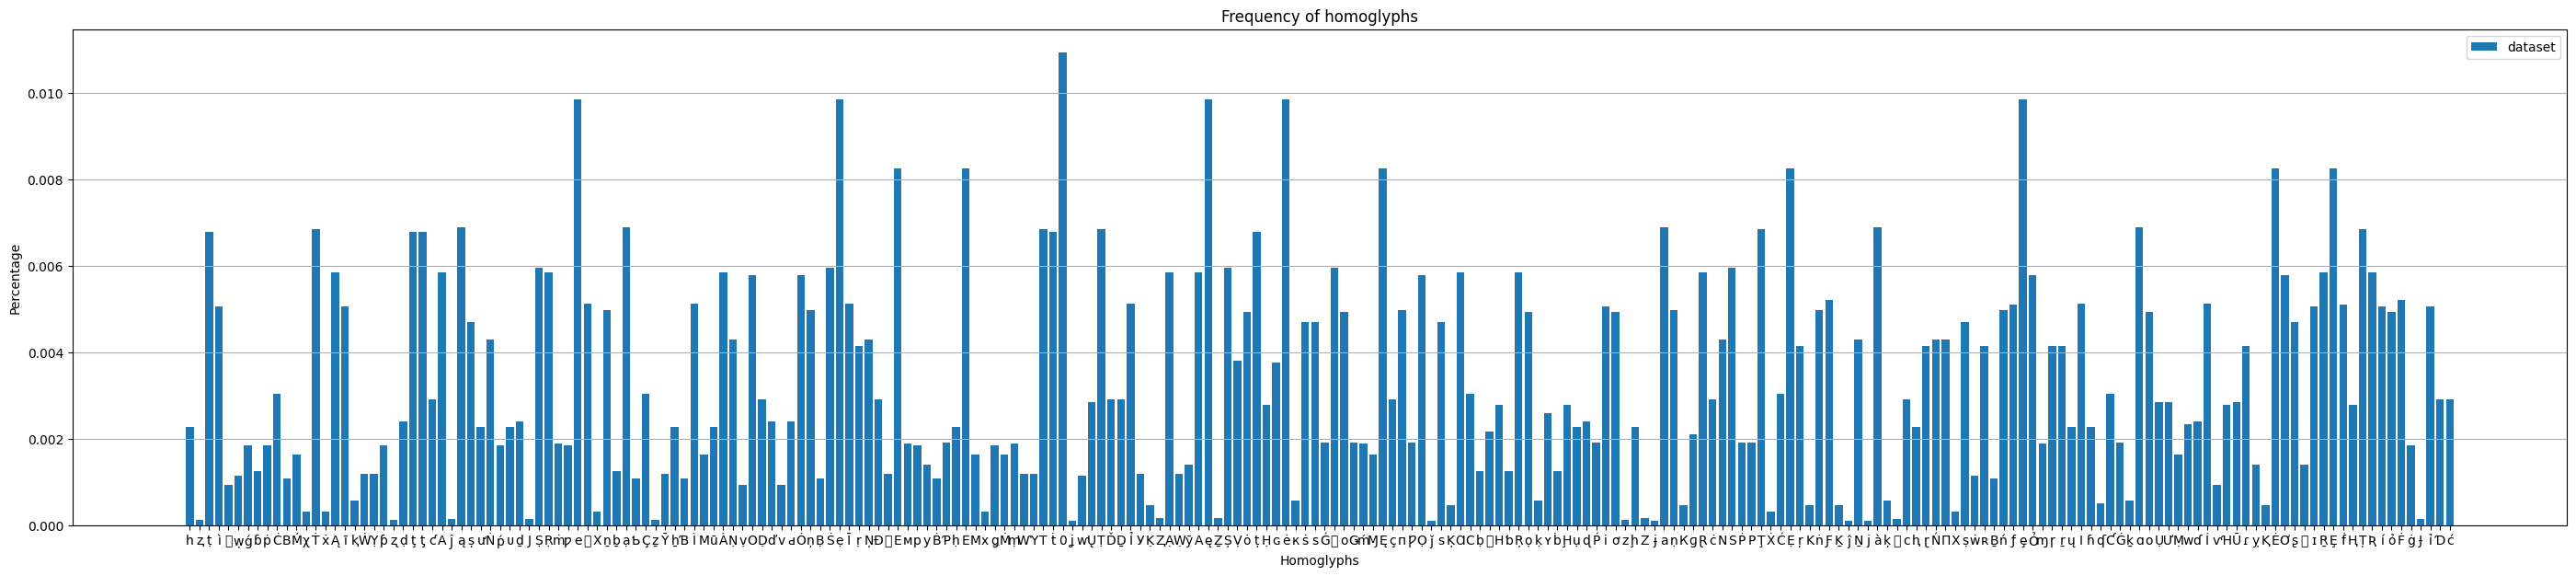

In [114]:
# homoglyphs = df_homoglyphs['letters']
# freq_dataset = df_homoglyphs['frequency']
# The symbols [I, 1, i, l] interfere with the construction of charts due to too large values
homoglyphs_without_il = df_homoglyphs[(df_homoglyphs['letters'] != 'I') & (df_homoglyphs['letters'] != '1') & (df_homoglyphs['letters'] != 'i') & (df_homoglyphs['letters'] != 'l')]

plt.figure(figsize=(35, 7))
plt.bar(homoglyphs_without_il['letters'], homoglyphs_without_il['frequency'], label='dataset')
plt.xlabel('Homoglyphs')
plt.ylabel('Percentage')
plt.title('Frequency of homoglyphs')
plt.legend()
plt.grid(True, axis='y')
plt.rc('axes', axisbelow=True)
plt.show()

In [105]:
#Calculating the frequency for the main glyph relative to its homoglyphs
lower_letters = list(glyphs_dict.keys())[:len(glyphs_dict)//2]
upper_letters = list(glyphs_dict.keys())[len(glyphs_dict)//2:]

lower_letters = dict(zip(lower_letters, [0]*len(lower_letters)))
upper_letters = dict(zip(upper_letters, [0]*len(upper_letters)))

homoglyphs_freq = dict(df_homoglyphs[['letters', 'frequency']].to_numpy())
homoglyphs_set = set(df_homoglyphs['letters'].to_list())

for letter in lower_letters:
  intersection = set(glyphs_dict[letter]) & homoglyphs_set
  for i in intersection:
    lower_letters[letter] += homoglyphs_freq[i]

for letter in upper_letters:
  intersection = set(glyphs_dict[letter]) & homoglyphs_set
  for i in intersection:
    upper_letters[letter] += homoglyphs_freq[i]

for letter in lower_letters:
  lower_letters[letter] *= 2

for letter in upper_letters:
  upper_letters[letter] *= 2

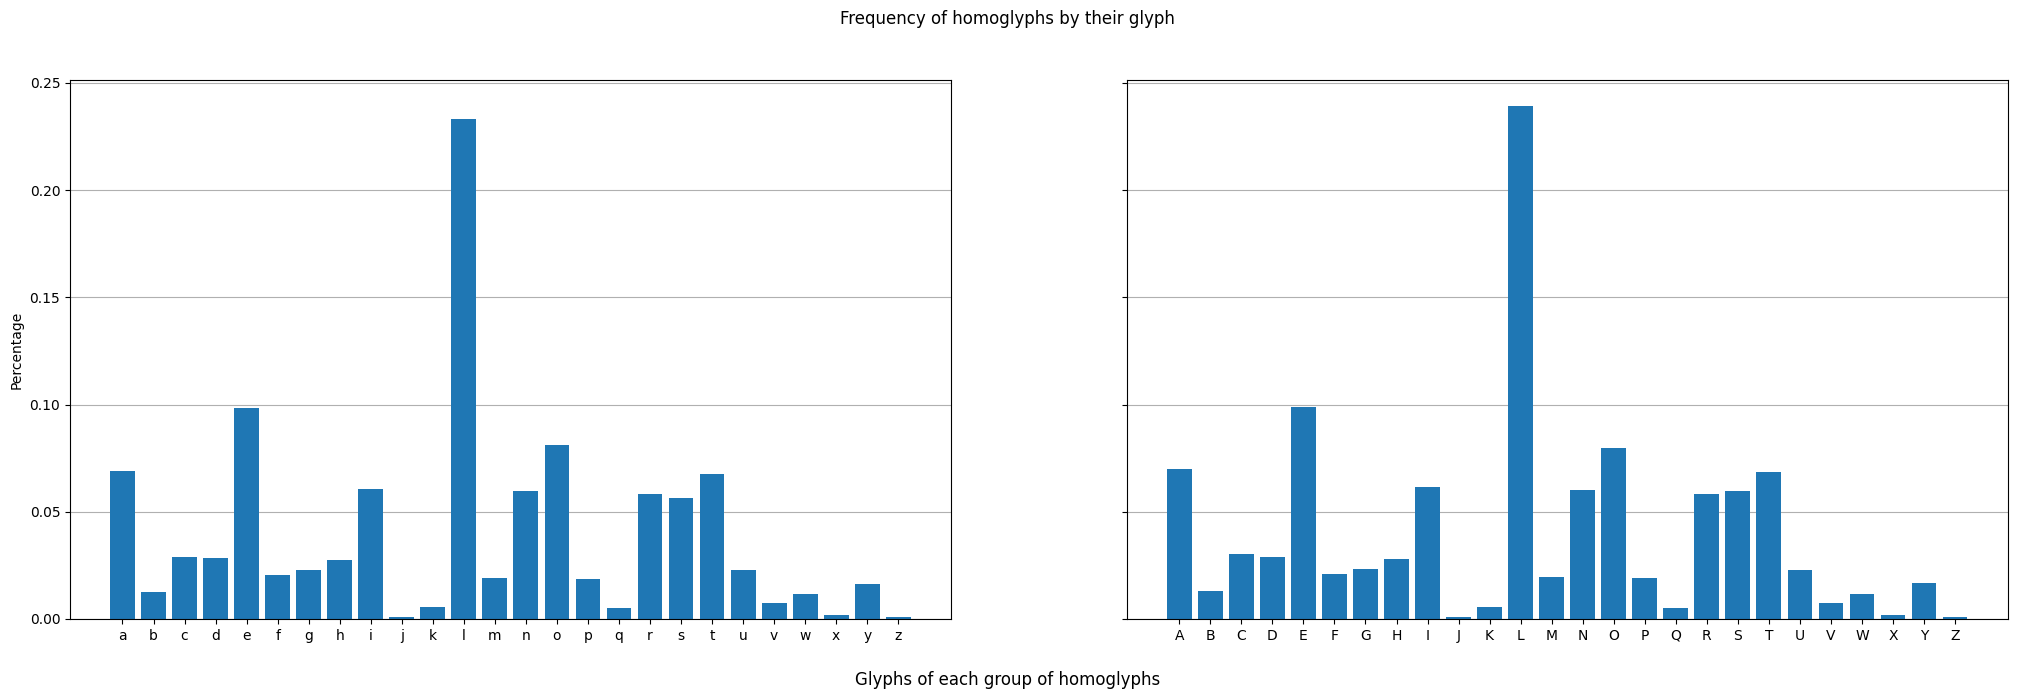

In [106]:
lower_x = list(lower_letters.keys())
lower_freq = list(lower_letters.values())

upper_x = list(upper_letters.keys())
upper_freq = list(upper_letters.values())

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.set_figheight(7)
fig.set_figwidth(25)
ax1.bar(lower_x, lower_freq)
ax2.bar(upper_x, upper_freq)
ax1.set_ylabel('Percentage')
ax1.grid(True, axis='y')
ax2.grid(True, axis='y')
fig.suptitle('Frequency of homoglyphs by their glyph')
fig.supxlabel('Glyphs of each group of homoglyphs')
plt.show()

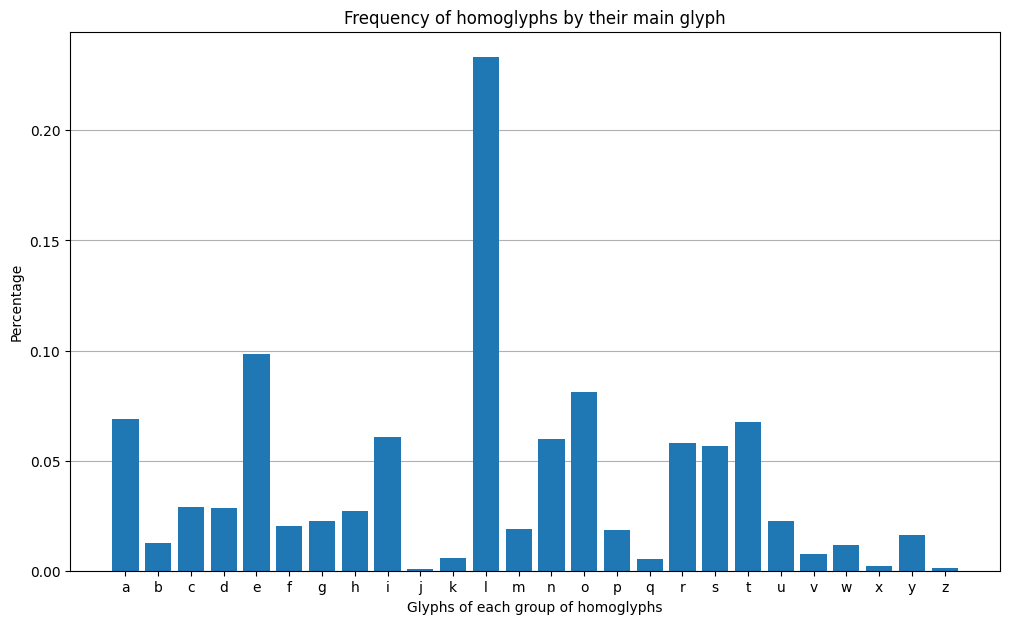

In [107]:
plt.figure(figsize=(12, 7))
plt.bar(lower_x, lower_freq, label='dataset')
plt.xlabel('Glyphs of each group of homoglyphs')
plt.ylabel('Percentage')
plt.title('Frequency of homoglyphs by their main glyph')
plt.grid(True, axis='y')
plt.rc('axes', axisbelow=True)
plt.show()